<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
from math import ceil
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
from datetime import datetime
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
# PATH_TO_DATA = ('/Users/y.kashnitsky/Documents/Machine_learning/ML_yandex_mipt_spec_repo/' + 
#                 'dev/final_project/capstone_user_identification')
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                              session_length=10, window_size=10):
    list_data = []
    
    columns = ['site' + str(i) for i in range(1,session_length + 1)]
    diff_time = ['time_diff' + str(j) for j in range(1,session_length)]
    
    path_to_each_files = glob(os.path.join(path_to_csv_files,'user*.csv'))
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)
    
    for path_to_file in path_to_each_files:
        file = pd.read_csv(path_to_file)
        a = [site_freq[site][0] for site in file['site']]
        tmp_1 = [datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in file['timestamp'].values]
        
        count_of_rows = ceil(len(a) / window_size)
        l = len(a) 
        y = [int(path_to_file[-8:-4])]
    
        for i in range(count_of_rows):
            nulls = session_length - l + i*window_size
            line = a[i*window_size : i*window_size + session_length]

            tmp_2 = tmp_1[i*window_size : i*window_size + session_length]
            time = [int((tmp_2[i] - tmp_2[i-1]).total_seconds()) for i in range(1,len(line))]
            line = (  line + [0]*(nulls)*(nulls > 0)    ## сайты в сессии
                    + time + [0]*(nulls)*(nulls > 0)    ## время в сессии
                    + [int(np.array(time).sum())]       ## время всей сессии
                    + [np.unique(line).shape[0]]        ## количество уникальных сайтов в сессии
                    + [tmp_2[0].hour]                   ## час начала сессии
                    + [tmp_2[0].weekday()]              ## день недели
                    + y)                                ## ID пользователя
            
            list_data = list_data + [line]
            
    data = pd.DataFrame(list_data, columns = feature_names)
    return data

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,3,3,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
1,4,5,2,5,2,5,5,6,7,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
2,4,5,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3
3,1,2,2,8,2,5,9,6,10,11,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
4,1,5,5,5,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1


In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,3,3,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
1,4,5,2,5,2,5,5,6,7,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
2,4,5,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3
3,1,2,2,8,2,5,9,6,10,11,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
4,1,5,5,5,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA,'10users'),
                                               site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                               feature_names=feature_names,
                                               session_length=10)


CPU times: user 4.35 s, sys: 53.5 ms, total: 4.4 s
Wall time: 4.42 s


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,4,4,4,5,5,6,0,1,480,0,1,1,0,2,2,487,6,8,4,39
1,7,8,7,4,9,10,11,12,9,13,1,0,3,0,1,0,1,5,19,30,8,8,4,39
2,14,15,15,9,15,9,9,4,4,9,0,1,0,1,21,25,4,1,3,56,4,8,4,39
3,12,15,15,16,17,13,18,19,20,21,56,1,31,0,0,3,0,0,0,91,9,8,4,39
4,22,23,19,21,24,19,25,26,21,19,0,1,0,1,0,0,0,1,1,4,7,8,4,39


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA,'150users'),
                                                site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                                feature_names=feature_names,
                                                session_length=10)


CPU times: user 3min 24s, sys: 4.06 s, total: 3min 28s
Wall time: 3min 30s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [8]:
new_features = (['time_diff' + str(j) for j in range(1,10)] + 
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target'])

In [9]:
train_data_10users[new_features]

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,0,1,480,0,1,1,0,2,2,487,6,8,4,39
1,1,0,3,0,1,0,1,5,19,30,8,8,4,39
2,0,1,0,1,21,25,4,1,3,56,4,8,4,39
3,56,1,31,0,0,3,0,0,0,91,9,8,4,39
4,0,1,0,1,0,0,0,1,1,4,7,8,4,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14056,82,109,49,13,163,266,38,3,68,791,4,15,1,237
14057,3,268,52,38,55,15,59,106,124,720,4,15,1,237
14058,62,4,28,0,32,9,4,25,0,164,6,16,1,237
14059,0,0,20,4,0,0,0,1,1,26,6,16,1,237


In [11]:
new_features_10users = train_data_10users[new_features]
new_features_150users = train_data_150users[new_features]

In [12]:
%%time
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

CPU times: user 9.04 ms, sys: 15.8 ms, total: 24.8 ms
Wall time: 31 ms


## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [12]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [13]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

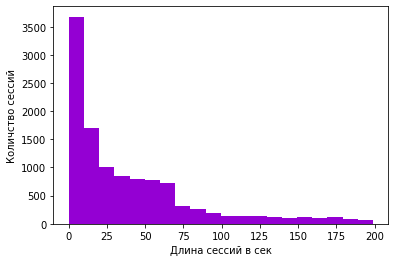

In [16]:
plt.hist(train_data_10users[train_data_10users['session_timespan'] < 200].session_timespan,
         bins=20,
         color='darkviolet')
plt.xlabel('Длина сессий в сек')
plt.ylabel('Количство сессий')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

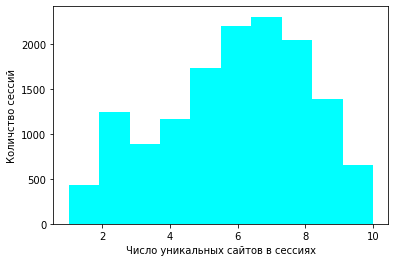

In [17]:
plt.hist(train_data_10users['#unique_sites'],
         color='aqua')
plt.xlabel('Число уникальных сайтов в сессиях')
plt.ylabel('Количство сессий')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

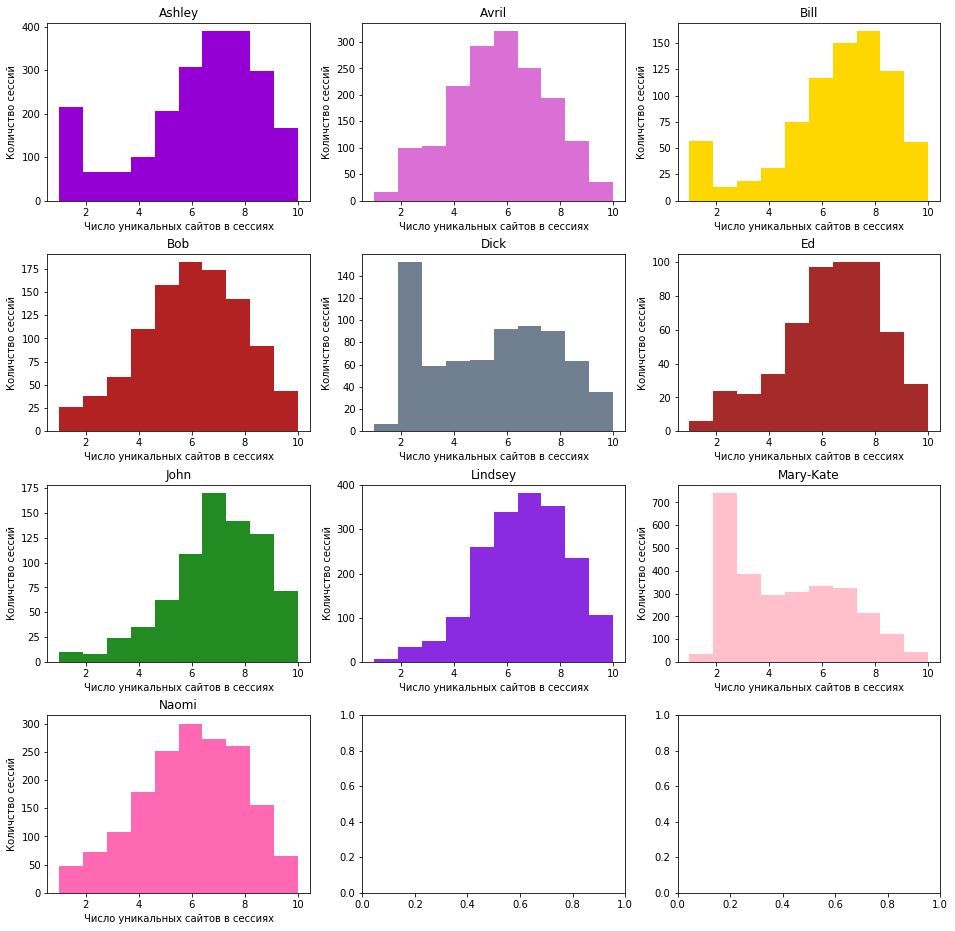

In [369]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(['target'])):
    axes[idx // 3, idx % 3].hist(sub_df['#unique_sites'], color=color_dic[user])
    axes[idx // 3, idx % 3].set_xlabel('Число уникальных сайтов в сессиях')
    axes[idx // 3, idx % 3].set_ylabel('Количство сессий')
    axes[idx // 3, idx % 3].set_title(user)
plt.subplots_adjust(hspace=0.3)
plt.show()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

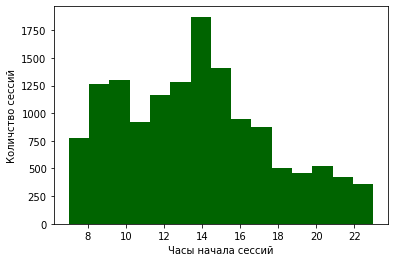

In [378]:
plt.hist(train_data_10users['start_hour'],
         color='darkgreen', bins=15)
plt.xlabel('Часы начала сессий')
plt.ylabel('Количство сессий')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

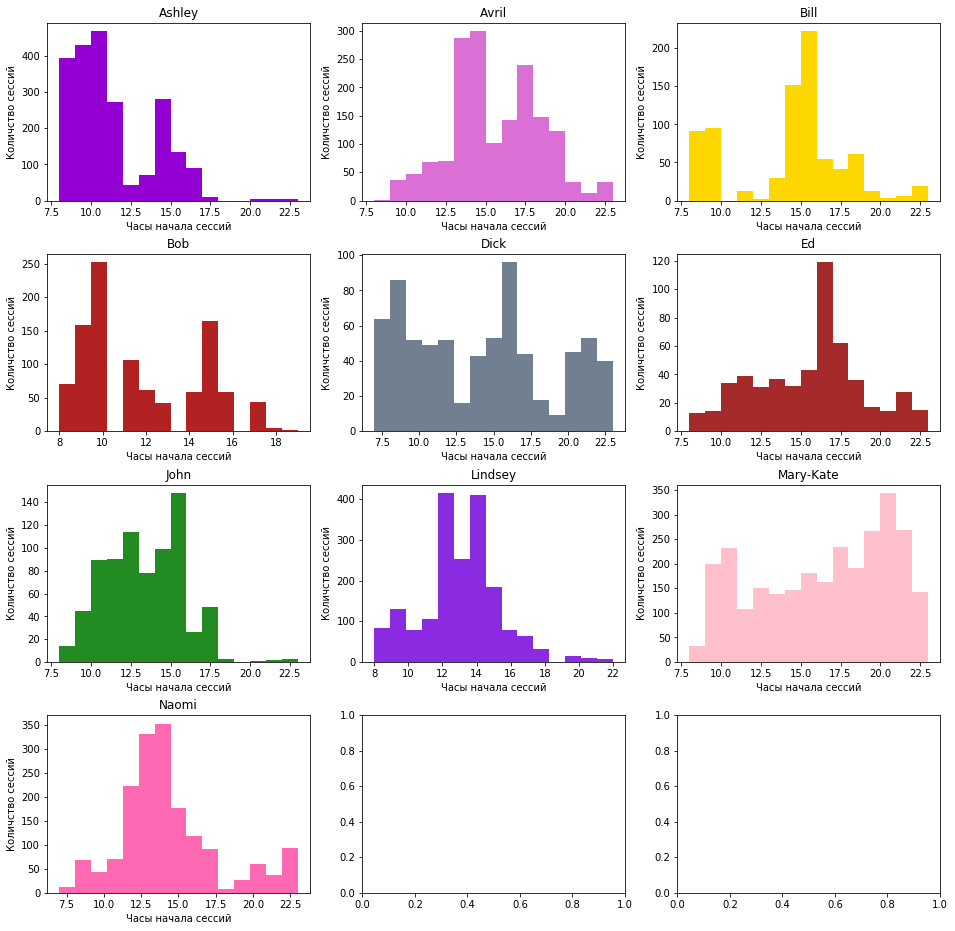

In [24]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(['target'])):
    axes[idx // 3, idx % 3].hist(sub_df['start_hour'], color=color_dic[user], bins=15)
    axes[idx // 3, idx % 3].set_xlabel('Часы начала сессий')
    axes[idx // 3, idx % 3].set_ylabel('Количство сессий')
    axes[idx // 3, idx % 3].set_title(user)
plt.subplots_adjust(hspace=0.3)
plt.show()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

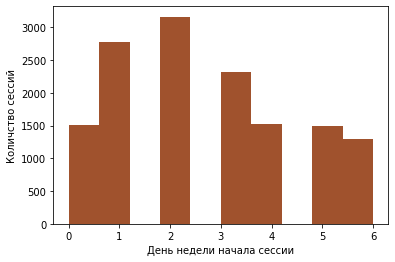

In [383]:
plt.hist(train_data_10users['day_of_week'],
         color='sienna')
plt.xlabel('День недели начала сессии')
plt.ylabel('Количство сессий')
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

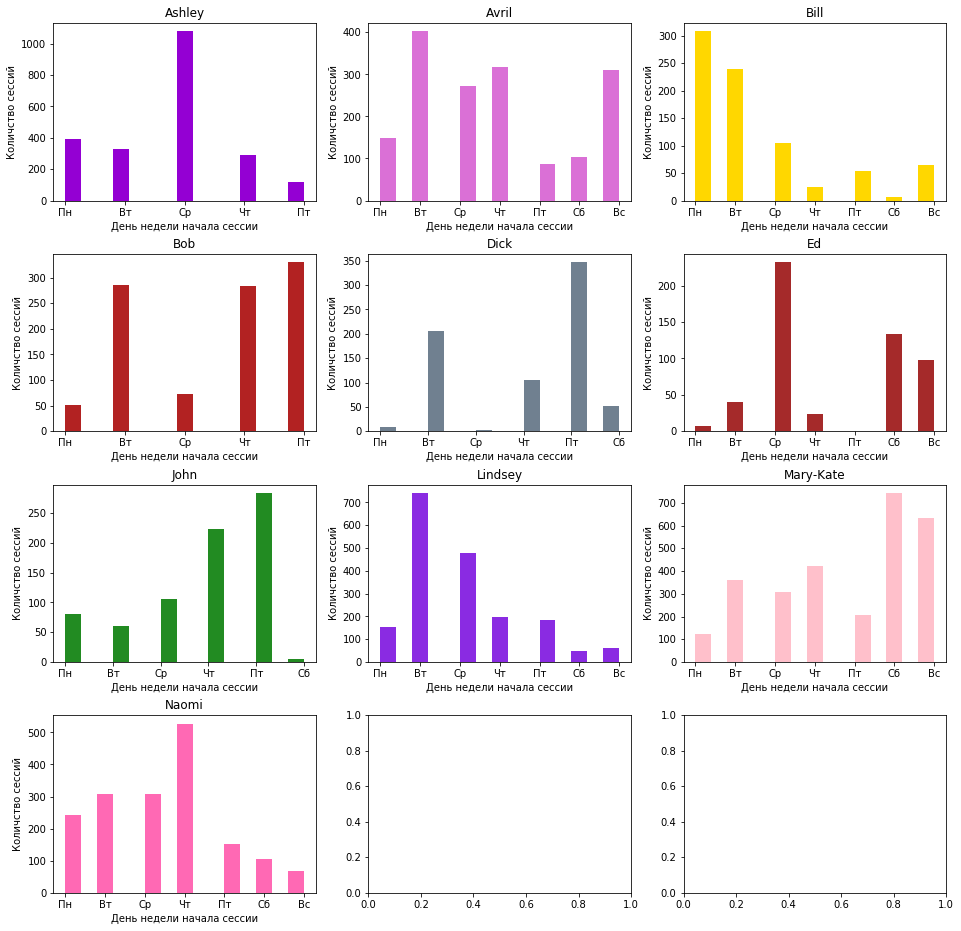

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(['target'])):
    axes[idx // 3, idx % 3].hist(sub_df['day_of_week'], color=color_dic[user], bins=15)
    axes[idx // 3, idx % 3].set_xlabel('День недели начала сессии')
    axes[idx // 3, idx % 3].set_ylabel('Количство сессий')
    axes[idx // 3, idx % 3].set_title(user)
    
    axes[idx // 3, idx % 3].set_xticklabels(['', 'Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.subplots_adjust(hspace=0.3)
plt.show()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''

**По всем гистограммам можно указать на некоторые общие моменты:** \
1) в среднем пик количества уникальных сайтов в сессии равно 6-7 \
2) в среднем активнее всего посещают сайты днем в районе 14:00, чуть меньше утром, а к вечеру активность падает \
3) в среднем активнее всего посеают сайты в среду по общей гистограмме, но если смотреть на каждого польщователя по отдельности, то это не так

**1)Ashley** \
Тяжелый левый хвост в гистограмме количеста уникальных сайтов (много сессий с одним сайтом). Возможно проверяет почту или сидив в сотсетях. \
Данный пользователь больше всего находится в сети утром до полудня, вечером - меньше всего. Похоже, что днем работает, а вечером отдыхает. \
Большая активность в Среду. Возможно это связанно с разгузочным днем или с конкретной работой.
  
**2)Avril** \
Очень типовое распределение количества уникальных сайтов. \
Активность появляется после часа дня, возможно после учебы. Далее есть просадка с 15:00 до 17:00. Возможно в этот период данный пользователь едет домой. \
По дням недели активность примерно равномерная с небольшими искажениями во вторник. А вот в пт и вс меньше всего активность, возможно в этот период преобладает активный отдых.

**3)Bill** \
Так же типовое распределение количества уникальных сайтов, только есть левый хвост, возможно связанный с посещением соцсетей. \
Можно отметить, что утром есть активность, возможно проверка почты, прогноза погоды, новостей и тд. Далее активность падает, но в районе двух часов дня появляется пиковая активность. Возможно это связанно с перерывом на работе. Далее активность падает \
Больше всего посещение в начале недели и постепенно падает. Возможно связанно с дэдлайнами на конец рабочей недели и с активным отдыхов в выходные 

**4)Bob** \
Распределение количества уникальных сайтов абсолютно типовое. \
Распределение начал сессий тоже типовое, все такие же пики в среднем. \
А вот активность по дням недели отличаются. По выходным больше всего посещений сайтов. Возможно пользователь не любит активный отдых или что-то вроде этого в данный период.

**5)Dick** \
Данный пользователь по  сравнению с остальными особо не сидит в сети, так как максимально кол-ва сайтов меньше на всех гистограммах. Активнее всего проверяются одни и те же сайты, а дальше примерно все равномерно. \
Активность можно наблюдать на протяжении всего активного дня. Свойственны типовые пики, вторые выше были обозначены для всех пользователей\
Больше всего сидит в сети в Пт. Сложно сказать, с чем это может быть связано, вариантов слишком много.

**6)Ed** \
Распределение количества уникальных сайтов абсолютно типовое.  \
Данный пользователь сидит в сети меньше всех, даже меньше чем Dick. Пик ближе к вечеру. Возможно возвращается на общественном транспорте домой и сидит в сети от скуки. \
Активность выше в среду и в выходные.

**7)John** \
Распределение количества уникальных сайтов скошено немного вправо. Возможно делает много запросов в поисковике, связанное с работой. \
Активнее всего до 18:00. Возможно работа связанна с активным использованием интернета. \
По дням недели выражена повышение активности к выходным. Затрудняюсь ответить на то, с чем это связанно.

**8)Lindsey** \
Распределение количества уникальных сайтов скошено немного вправо. Возможно делает много запросов в поисковике, связанное с работой. \
Активнее всего до 18:00. Возможно работа связанна с активным использованием интернета, но пики приходятся на отрезки 12-13 и 14-15. Возможно в эти периоды перерыв. \
Со вторника активность в сети падает, а в выходные меньше всего

**9)Mary-Kate** \
Распределение количества уникальных сайтов похоже на распределение Dick’а. \
По времени начала сессий можно сказать, что пользователь примерно равномерно пользуется сетью, но есть пики утром и вечером. \
Можно выбелить большое использование интернета в выходные.

**10)Naom** \
Распределение количества уникальных сайтов абсолютно типовое. \
Распределение часов активности похоже на распределение Avril’а. \
В будни активность примерно равномерная, но в четверг выше среднего, а в пятницу - падает. В выходные меньше всего


**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [27]:
with open(os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'), 'rb') as f:
    site_freq_10users = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [29]:
top10_sites = [k for k, v in sorted(site_freq_10users.items(), key=lambda item: item[1][1], reverse=True)][0:10]
top10_freqs = [v[1] for k, v in sorted(site_freq_10users.items(), key=lambda item: item[1][1], reverse=True)][0:10]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

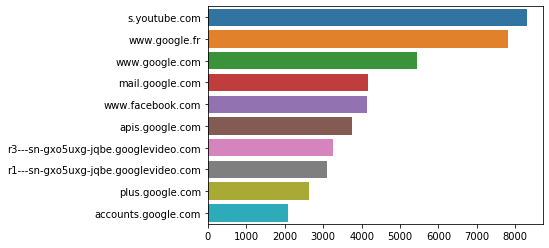

In [30]:
sns.barplot(x=top10_freqs, y=top10_sites)

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [31]:
''' ВАШ КОД ЗДЕСЬ ''' 
print('Медианная продолжительность сессии для 10 пользователей равна',
      np.median(train_data_10users['session_timespan'].values))

Медианная продолжительность сессии для 10 пользователей равна 37.0


**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [18]:
''' ВАШ КОД ЗДЕСЬ '''
print('Медианный день недели, в который началась сессия, для сессий 10 пользователей - это',
      np.median(train_data_10users['day_of_week'].values), 'т.е. Ср')

Медианный день недели, в который началась сессия, для сессий 10 пользователей - это 2.0 т.е. Ср


**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [33]:
''' ВАШ КОД ЗДЕСЬ ''' 
print('Медианный час начала сессии для сессий 150 пользователей равен',
      np.median(train_data_150users['start_hour'].values))

Медианный час начала сессии для сессий 150 пользователей равен 13.0


**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [34]:
''' ВАШ КОД ЗДЕСЬ ''' 
print('Медианное значение числа уникальных сайтов в сессиях 150 пользователей равно',
      np.median(train_data_150users['#unique_sites'].values))

Медианное значение числа уникальных сайтов в сессиях 150 пользователей равно 7.0


## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

Я считаю, что можно добавить такие признаки как: посещение facebook и почты, среднее времяпрепровждение на сайтах из TOP 30. Facebook и почта важны тем, что через эти сайты возможны взомы, поэтому это очень важный параметр!

In [347]:
def feature_engineering(path_to_csv_files, site_freq_path, session_length=10):
    '''
    ВАШ КОД ЗДЕСЬ
    ''' 
    list_data = []
    window_size = session_length
    
    search_ids = []
    search_name = ['facebook','mail']
    search_name_len = len(search_name)
    
    columns = ['site' + str(i) for i in range(1,session_length + 1)]
    diff_time = ['time_diff' + str(j) for j in range(1,session_length)]
    feature_names = columns + diff_time + ['session_timespan', 'Average_time_on_top30_sites',
                                           'facebook', 'mail', 'target']
    
    path_to_each_files = glob(os.path.join(path_to_csv_files,'user*.csv'))
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)
    
    for search in search_name:
        ids = []
        for site in site_freq:
            if search in site:
                ids += [site_freq[site][0]]
        search_ids += [ids]
    
    top30 = [v[0] for k, v in sorted(site_freq.items(), key=lambda item: item[1][1], reverse=True)][0:10]
    
    for path_to_file in path_to_each_files:
        file = pd.read_csv(path_to_file)
        a = [site_freq[site][0] for site in file['site']]
        tmp_1 = [datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in file['timestamp'].values]
        
        count_of_rows = ceil(len(a) / window_size)
        l = len(a) 
        y = [int(path_to_file[-8:-4])]
    
        for i in range(count_of_rows):
            nulls = session_length - l + i*window_size
            line = a[i*window_size : i*window_size + session_length]
            
            ## Считаем время посещения каждого сайта в сессии
            tmp_2 = tmp_1[i*window_size : i*window_size + session_length]
            time = [(tmp_2[i] - tmp_2[i-1]).total_seconds() for i in range(1,len(line))]
            
            ## Считаем количество посещений важных сайтов за одну сессию
            count_of_search_names = [0] * search_name_len
            for j in range(search_name_len):
                for id_ in line:
                    if id_ in search_ids[j]:
                        count_of_search_names[j] += 1
            
            ## Считаем среднее время посещения сайта из TOP 30 за одну сессию.
            ## Если в сессии не было сайтов из TOP 30, то будем возвращать им значения -1
            count_of_match_with_top = 0
            time_of_top = 0
            for k, id_ in enumerate(line):
                if (id_ in top30) & (k < len(line) - 1):
                    time_of_top += time[k]
                    count_of_match_with_top += 1
            if count_of_match_with_top != 0:
                Average_time_on_top30_sites = time_of_top / count_of_match_with_top
            else:
                Average_time_on_top30_sites = -1
            
            ## Получаем итоговую строчку в датафрейме для одной сессии
            line = (  line + [0]*(nulls)*(nulls > 0)      ## сайты в сессии
                    + time + [0]*(nulls)*(nulls > 0)      ## время между сайтами в сессии
                    + [np.array(time).sum()]              ## время всей сессии
                    + [Average_time_on_top30_sites]       ## среднее время на сайте из Top 30
                    + [count_of_search_names[0]]          ## количество посещений facebook (всех вариаций ссылок)
                    + [count_of_search_names[1]]          ## количество посещений mail (всех вариаций ссылок)
                    + y)                                  ## ID пользователя
            
            list_data = list_data + [line]
            
    data = pd.DataFrame(list_data, columns = feature_names)
    return data

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [338]:
data_10users = feature_engineering(os.path.join(PATH_TO_DATA,'10users'),
                                           site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                           session_length=10)
data_10users['target'] = data_10users['target'].map(id_name_dict)

In [337]:
%%time
data_10users = feature_engineering(os.path.join(PATH_TO_DATA,'10users'),
                                   site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                   session_length=10)

CPU times: user 4.36 s, sys: 54.4 ms, total: 4.41 s
Wall time: 4.46 s


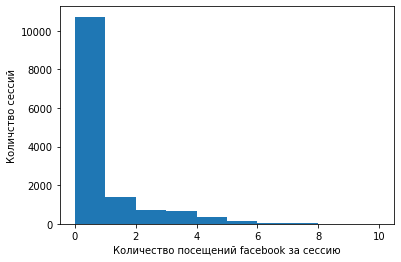

In [340]:
plt.hist(data_10users['facebook'])
plt.xlabel('Количество посещений facebook за сессию')
plt.ylabel('Количство сессий')
plt.show()

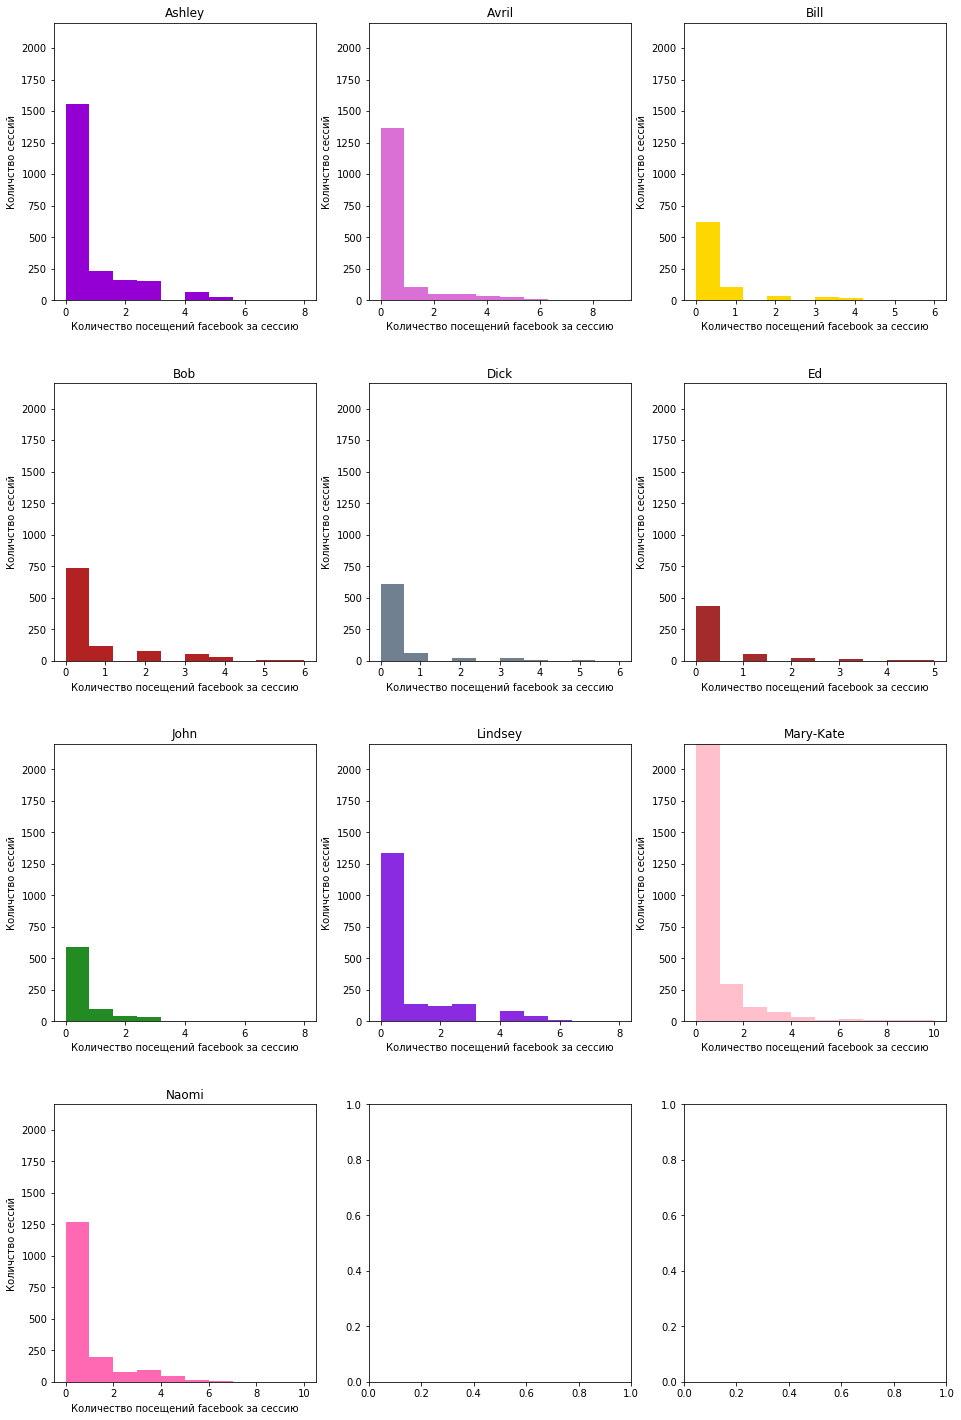

In [350]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 25))

for idx, (user, sub_df) in  enumerate(data_10users.groupby(['target'])):
    axes[idx // 3, idx % 3].set_ylim(0, 2200)
    axes[idx // 3, idx % 3].hist(sub_df['facebook'], color=color_dic[user], bins=10)
    axes[idx // 3, idx % 3].set_xlabel('Количество посещений facebook за сессию')
    axes[idx // 3, idx % 3].set_ylabel('Количство сессий')
    axes[idx // 3, idx % 3].set_title(user)
plt.subplots_adjust(hspace=0.3)
plt.show()

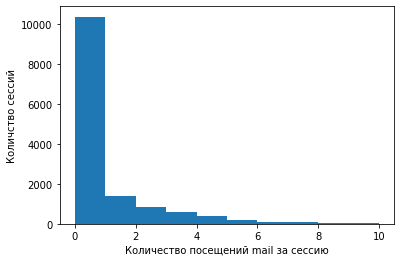

In [342]:
plt.hist(data_10users['mail'])
plt.xlabel('Количество посещений mail за сессию')
plt.ylabel('Количство сессий')
plt.show()

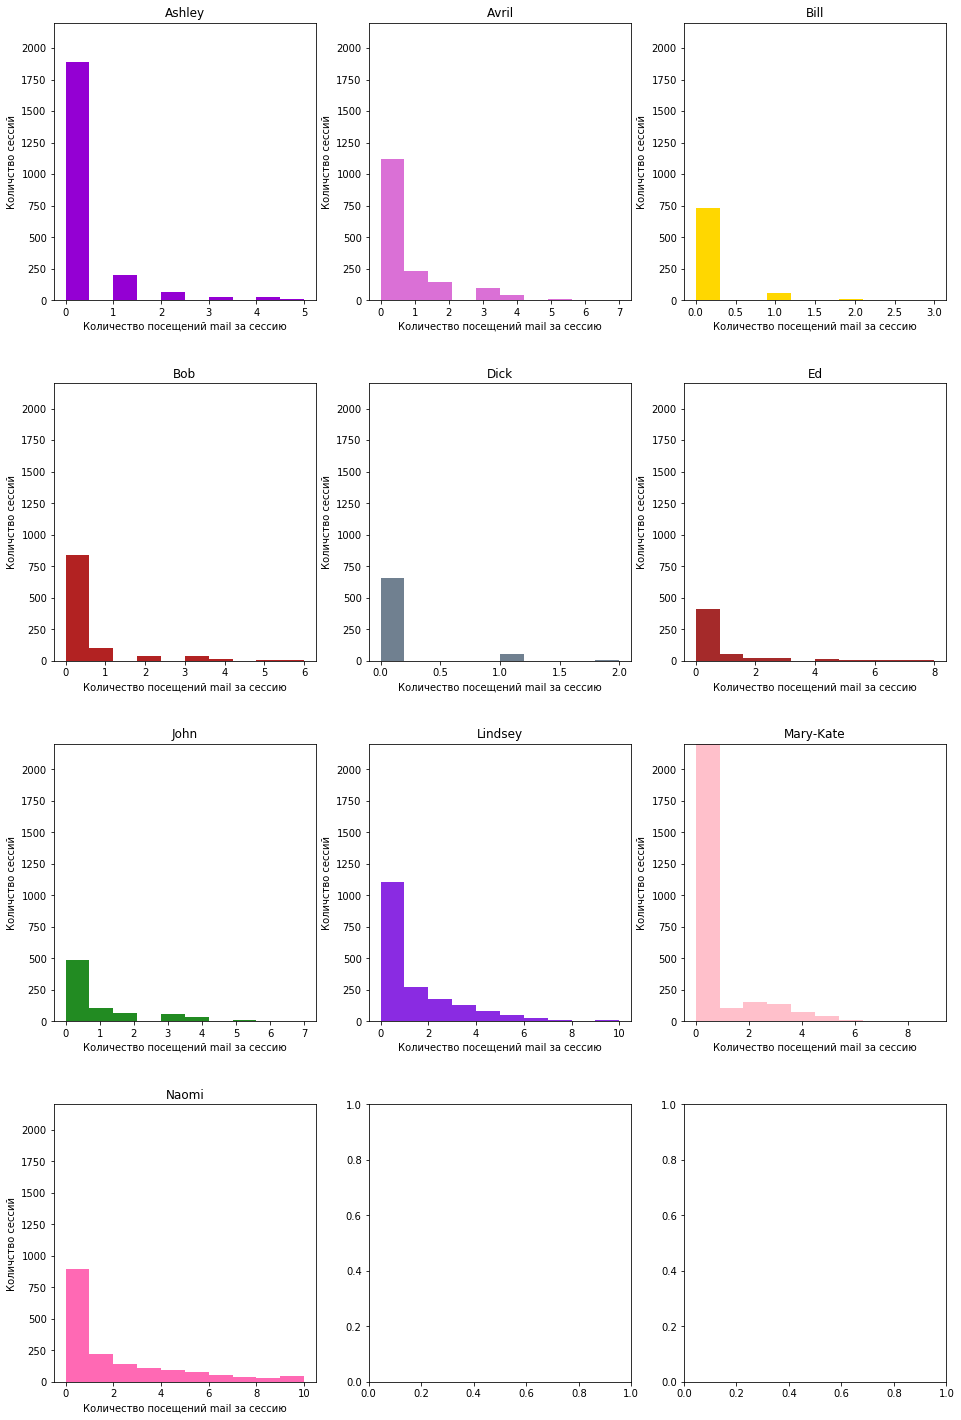

In [351]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 25))

for idx, (user, sub_df) in  enumerate(data_10users.groupby(['target'])):
    axes[idx // 3, idx % 3].set_ylim(0, 2200) ## для сравнения с facebook
    axes[idx // 3, idx % 3].hist(sub_df['mail'], color=color_dic[user], bins=10)
    axes[idx // 3, idx % 3].set_xlabel('Количество посещений mail за сессию')
    axes[idx // 3, idx % 3].set_ylabel('Количство сессий')
    axes[idx // 3, idx % 3].set_title(user)
plt.subplots_adjust(hspace=0.3)
plt.show()

Про посещение facebook и почты можно сказать, что чаще всего из посещают несколько раз за сессию, возможно потому что либо не заходят на эти сайты, либо изредка проверить что-то или ответить кому-то. Мало кто сиди без остановки на одном таком сайте, точнее такое происходит редко. По гистограммам можно сделать вывод, что распределения очень похожи, поэтому можно оставить только один из них. Я думаю, что стоит отсавить facebook, т.к. он более информативный. 

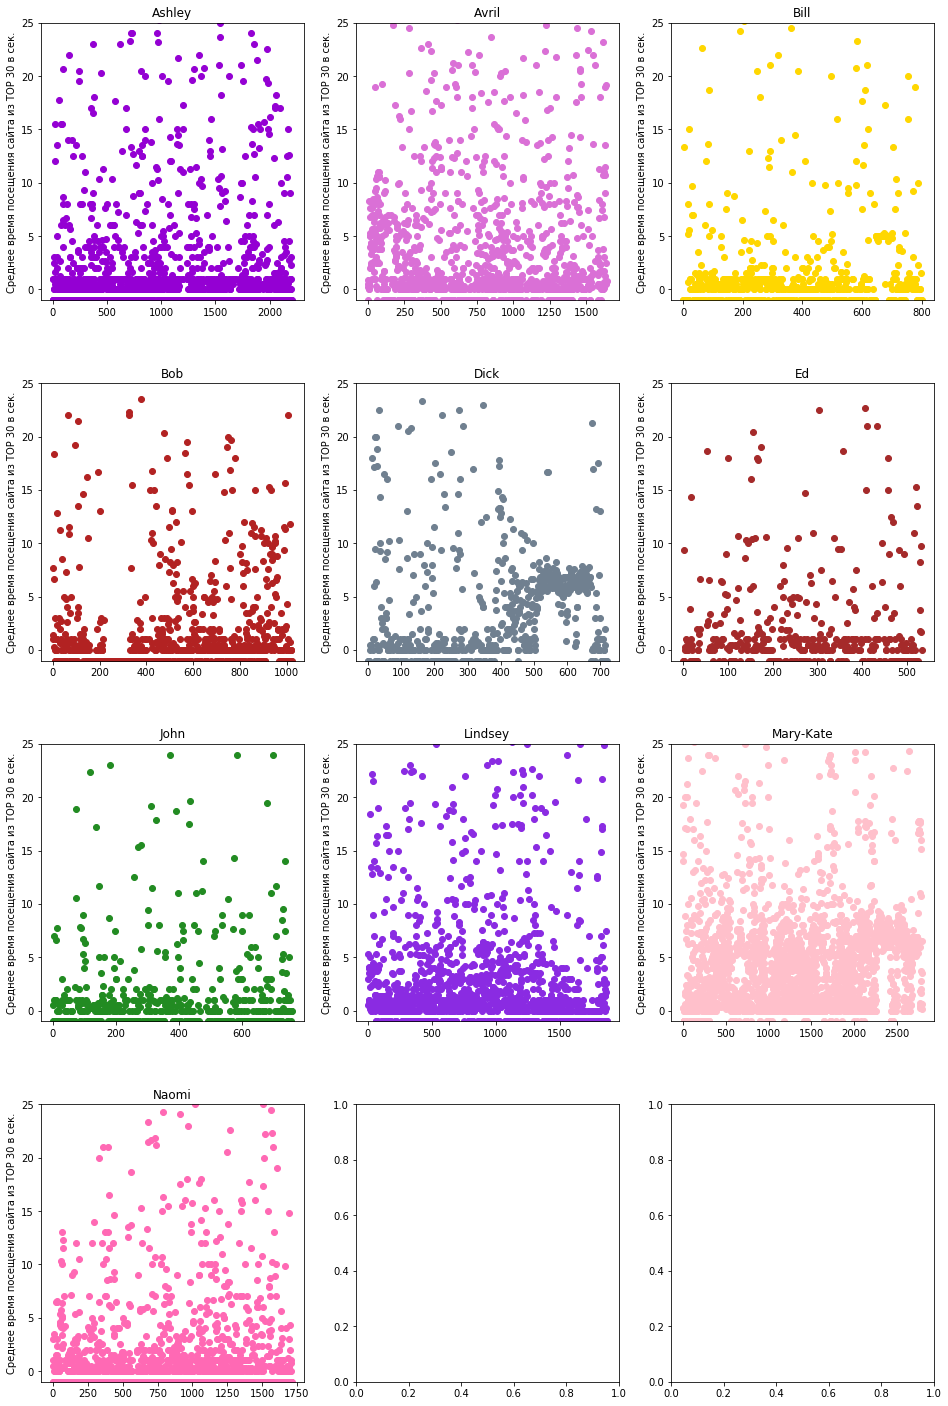

In [385]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 25))

for idx, (user, sub_df) in  enumerate(data_10users.groupby(['target'])):
    axes[idx // 3, idx % 3].set_ylim(-1, 25)
    axes[idx // 3, idx % 3].scatter(y=sub_df['Average_time_on_top30_sites'],
                                    x=np.arange(len(sub_df['Average_time_on_top30_sites'])),
                                    color=color_dic[user])
    axes[idx // 3, idx % 3].set_ylabel('Среднее время посещения сайта из TOP 30 в сек.')
    axes[idx // 3, idx % 3].set_title(user)
plt.subplots_adjust(hspace=0.3)
plt.show()


Я специально таким образом изобразил результаты, потому что смотреть все неудобно, т.к. из-за больших выбросов (например, просмотр видео на ютубе) нижняя часть сильно слепливается  в линию. Можно отметить, что у Ashley, Lindsey и Bill очень много посещений сайтов за меньше чем за одну секунду. Это важной момент. 
Mary-Kate ведет себя не так как все. Значение данной величины примерно до 10, но эта область очень плотная. А вот у оставшихся посещение сайтов достаточно долгое, т.к. плотность точек маленькая, даже в районе нуля (в сравнением с остальными)


**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

Из признаков, которые были даны в самом задании достаточно информативны, поэтому считаю, что стоит из оставить. В любом случае еще успеем выбросить. Из моих можно оставить посещение facebook и отношение общего времени посещения популярных сайтов в сессии к количеству самих сайтов.

In [417]:
%%time
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA,'10users'),
                                           site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                           session_length=10)[['Average_time_on_top30_sites',
                                                               'facebook', 
                                                               'target']]

CPU times: user 4.45 s, sys: 57.1 ms, total: 4.51 s
Wall time: 4.55 s


In [422]:
%%time
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA,'150users'),
                                           site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                           session_length=10)[['Average_time_on_top30_sites',
                                                               'facebook', 
                                                               'target']]

CPU times: user 3min 41s, sys: 4.31 s, total: 3min 45s
Wall time: 3min 50s


In [425]:
selected_features_10users = pd.concat([train_data_10users.iloc[:,0:23], new_features_10users], axis=1)
selected_features_150users = pd.concat([train_data_150users.iloc[:,0:23], new_features_150users], axis=1)

In [428]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=4)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 